In [7]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
import kagglehub
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from tqdm import tqdm
import os
import glob
import cv2
from PIL import Image
import pandas as pd
from torchmetrics import JaccardIndex
from datasets import load_dataset
from IPython.display import display
from torch.optim.lr_scheduler import CyclicLR, OneCycleLR, CosineAnnealingWarmRestarts, LinearLR
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from matplotlib.colors import ListedColormap
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchmetrics import JaccardIndex


from torchvision.transforms import v2
from torch.utils.data import DataLoader
import PIL.Image
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision import tv_tensors
import segmentation_models_pytorch as smp
from torchinfo import summary


In [6]:
# # # # !pip install torchmetrics
# # # ! pip install -U datasets
# # !pip install segmentation_models_pytorch
# !pip install torchinfo

In [8]:
seed = 42
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True #False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)
gpu_name = torch.cuda.get_device_name(device)
print(f"GPU Name: {gpu_name}")

Using device cuda:0
GPU Name: Tesla T4


In [9]:
from datasets import load_dataset
dir = "./sample_data"
ds = load_dataset("EPFL-ECEO/coralscapes", cache_dir=dir)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

train-00000-of-00009.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

train-00001-of-00009.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

train-00002-of-00009.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00003-of-00009.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00004-of-00009.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

train-00005-of-00009.parquet:   0%|          | 0.00/415M [00:00<?, ?B/s]

train-00006-of-00009.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00007-of-00009.parquet:   0%|          | 0.00/520M [00:00<?, ?B/s]

train-00008-of-00009.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

test-00000-of-00003.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

test-00001-of-00003.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

test-00002-of-00003.parquet:   0%|          | 0.00/358M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1517 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/166 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/392 [00:00<?, ? examples/s]

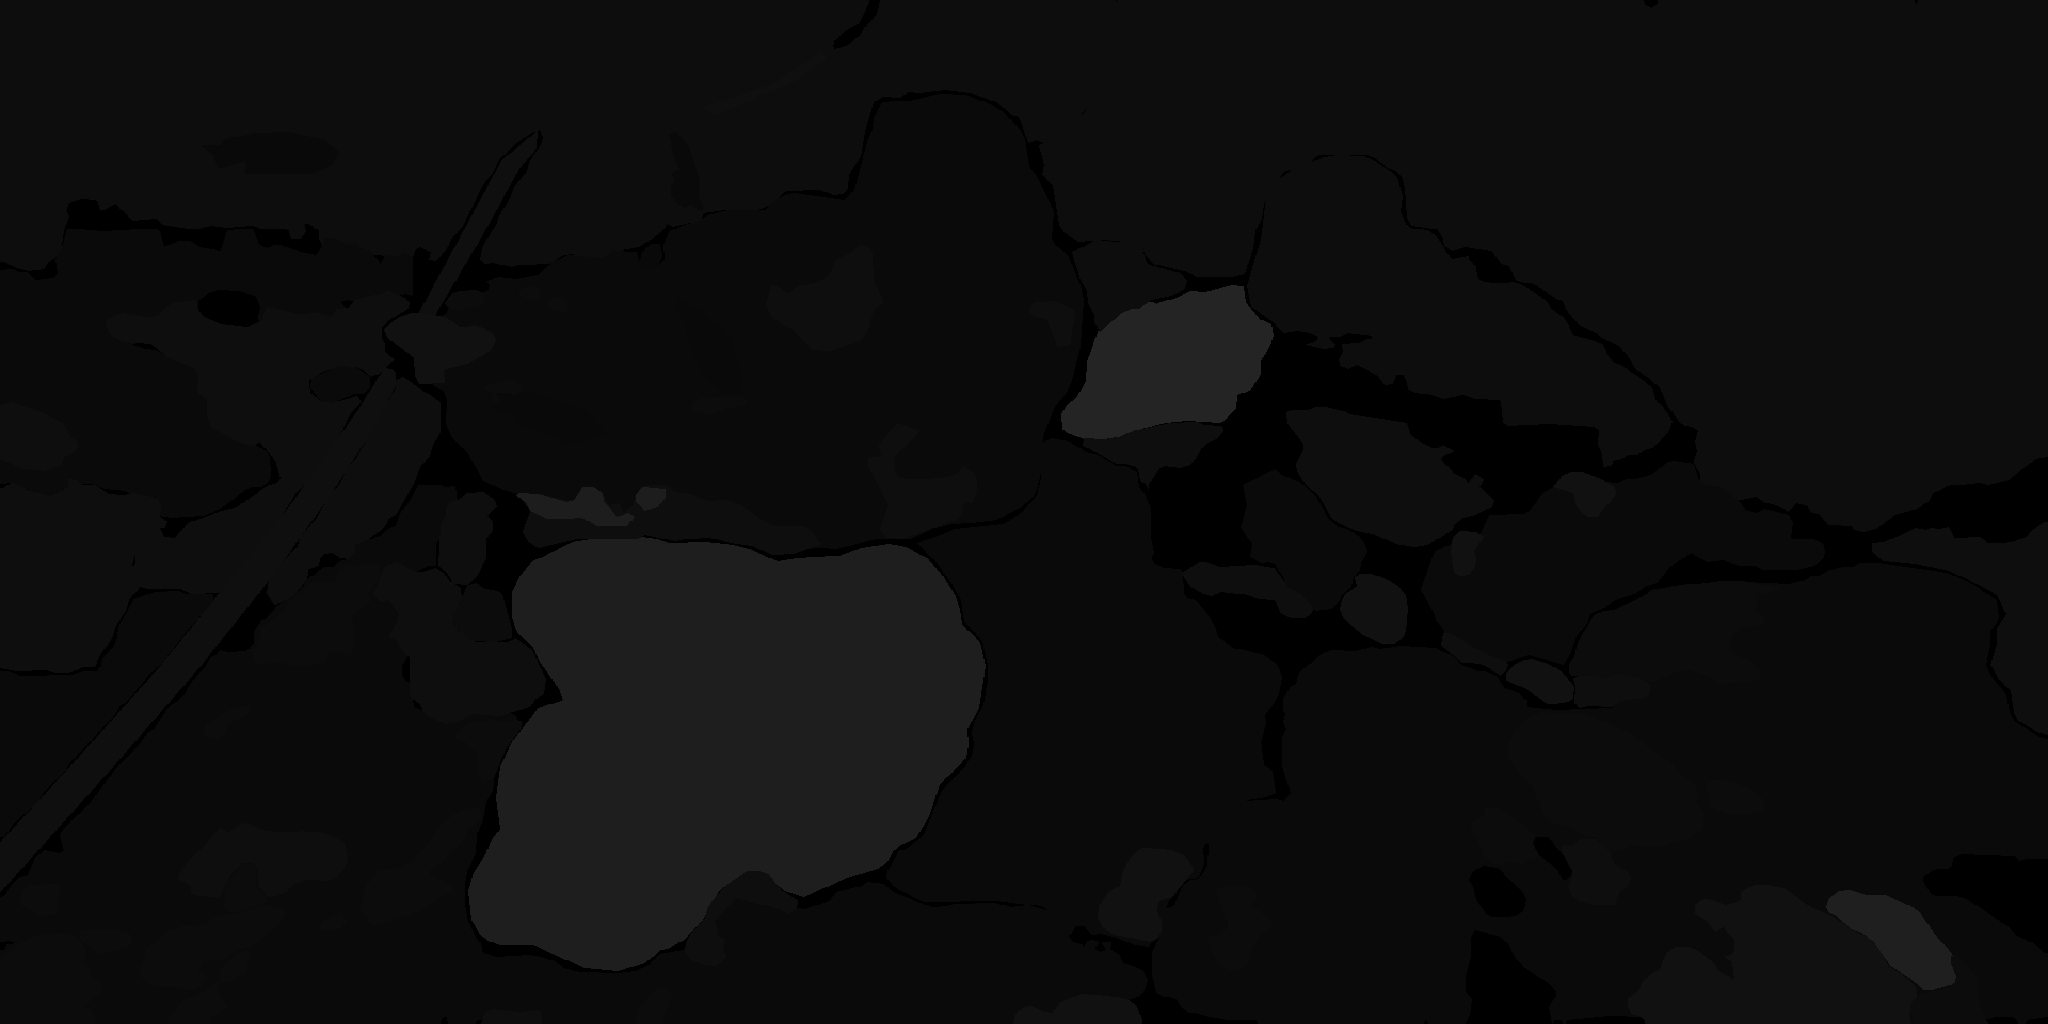

(1024, 2048)


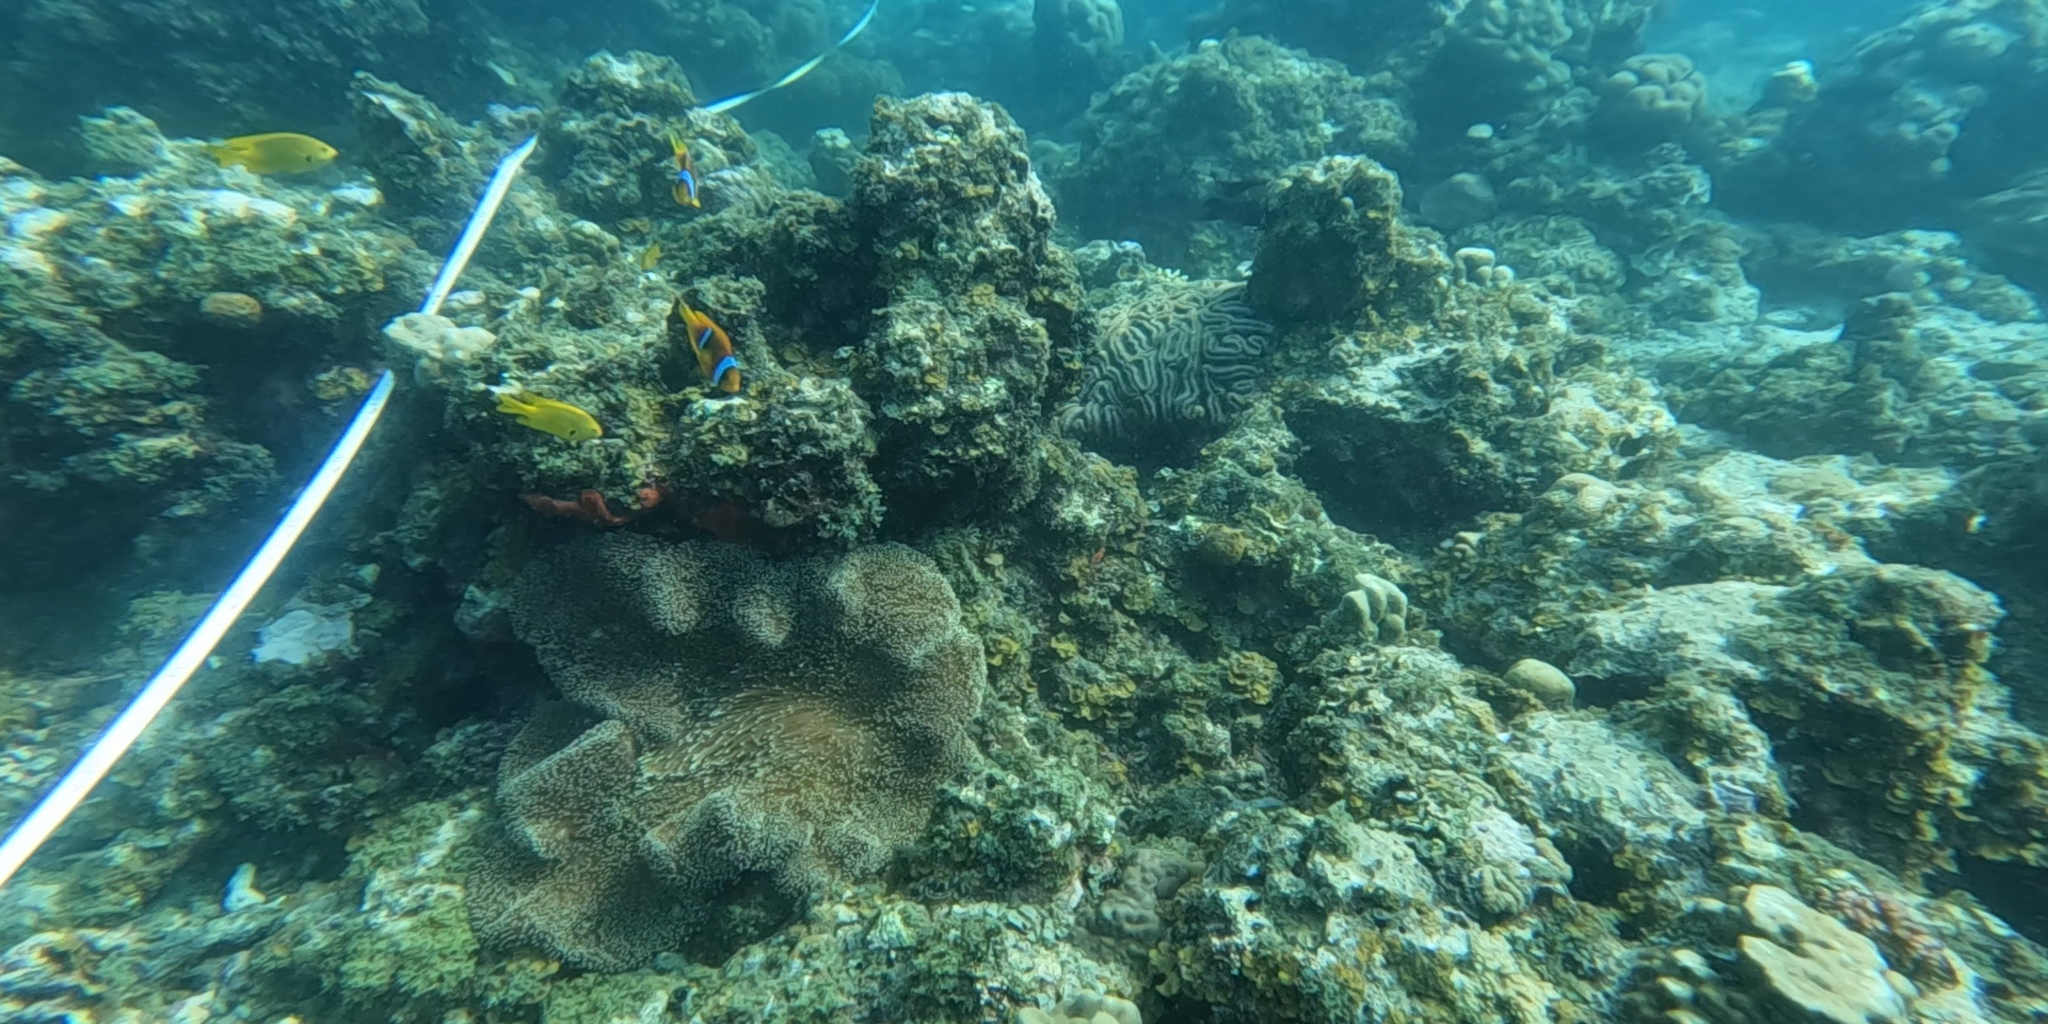

In [10]:
sample = ds['train'][0]
image = sample['image']
mask = sample['label']
display(mask)
print(np.shape(mask))
display(image)

dataset Structure


In [11]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1517
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 166
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 392
    })
})

Label Defination

In [12]:
from collections import namedtuple

Label = namedtuple('Label', [
    'name',
    'id',
    'trainId',
    'category',
    'categoryId',
    'hasInstances',
    'ignoreInEval',
    'color',
])

# Category mapping (custom, feel free to adjust)
category_map = {
    'coral': 0,
    'animal': 1,
    'substrate': 2,
    'human': 3,
    'object': 4,
    'plant': 5,
    'trash': 6,
    'unknown': 7,
    'void': 8
}

labels = [
    #              name                       id  trainId  category           categoryId  hasInstances  ignoreInEval  color
    Label('unlabeled',                        0,     255,  'void',            category_map['void'],     False,       True,   (255, 255, 255)),
    Label('seagrass',                         1,       0,  'plant',           category_map['plant'],    False,       False,  (125, 222, 125)),
    Label('trash',                            2,       1,  'trash',           category_map['trash'],    False,       False,  (255, 0, 134)),
    Label('other coral dead',                 3,       2,  'coral',           category_map['coral'],    False,       False,  (114, 60, 61)),
    Label('other coral bleached',             4,       3,  'coral',           category_map['coral'],    False,       False,  (250, 224, 225)),
    Label('sand',                             5,       4,  'substrate',       category_map['substrate'],False,       False,  (194, 178, 128)),
    Label('other coral alive',                6,       5,  'coral',           category_map['coral'],    False,       False,  (224, 118, 119)),
    Label('human',                            7,       6,  'human',           category_map['human'],    True,        False,  (255, 0, 0)),
    Label('transect tools',                   8,       7,  'object',          category_map['object'],   False,       False,  (8, 205, 12)),
    Label('fish',                             9,       8,  'animal',          category_map['animal'],   True,        False,  (255, 255, 0)),
    Label('algae covered substrate',         10,       9,  'substrate',       category_map['substrate'],False,       False,  (125, 163, 125)),
    Label('other animal',                    11,      10,  'animal',          category_map['animal'],   False,       False,  (0, 255, 255)),
    Label('unknown hard substrate',          12,      11,  'unknown',         category_map['unknown'],  False,       False,  (125, 125, 125)),
    Label('background',                      13,      255, 'void',            category_map['void'],     False,       True,   (29, 162, 216)),
    Label('dark',                            14,      255, 'void',            category_map['void'],     False,       True,   (31, 31, 31)),
    Label('transect line',                   15,      12,  'object',          category_map['object'],   False,       False,  (0, 255, 0)),
    Label('massive/meandering bleached',     16,      13,  'coral',           category_map['coral'],    False,       False,  (255, 248, 228)),
    Label('massive/meandering alive',        17,      14,  'coral',           category_map['coral'],    False,       False,  (236, 150, 21)),
    Label('rubble',                          18,      15,  'substrate',       category_map['substrate'],False,       False,  (161, 153, 128)),
    Label('branching bleached',             19,      16,  'coral',           category_map['coral'],    False,       False,  (252, 231, 240)),
    Label('branching dead',                 20,      17,  'coral',           category_map['coral'],    False,       False,  (123, 50, 86)),
    Label('millepora',                       21,      18,  'coral',           category_map['coral'],    False,       False,  (244, 150, 115)),
    Label('branching alive',                22,      19,  'coral',           category_map['coral'],    False,       False,  (226, 91, 157)),
    Label('massive/meandering dead',        23,      20,  'coral',           category_map['coral'],    False,       False,  (134, 86, 18)),
    Label('clam',                            24,      21,  'animal',          category_map['animal'],   False,       False,  (189, 255, 234)),
    Label('acropora alive',                  25,      22,  'coral',           category_map['coral'],    False,       False,  (236, 128, 255)),
    Label('sea cucumber',                    26,      23,  'animal',          category_map['animal'],   False,       False,  (0, 231, 255)),
    Label('turbinaria',                      27,      24,  'coral',           category_map['coral'],    False,       False,  (228, 255, 119)),
    Label('table acropora alive',            28,      25,  'coral',           category_map['coral'],    False,       False,  (189, 119, 255)),
    Label('sponge',                          29,      26,  'animal',          category_map['animal'],   False,       False,  (240, 80, 80)),
    Label('anemone',                         30,      27,  'animal',          category_map['animal'],   False,       False,  (0, 255, 189)),
    Label('pocillopora alive',              31,      28,  'coral',           category_map['coral'],    False,       False,  (255, 146, 150)),
    Label('table acropora dead',            32,      29,  'coral',           category_map['coral'],    False,       False,  (85, 53, 116)),
    Label('meandering bleached',            33,      30,  'coral',           category_map['coral'],    False,       False,  (251, 243, 216)),
    Label('stylophora alive',               34,      31,  'coral',           category_map['coral'],    False,       False,  (255, 111, 194)),
    Label('sea urchin',                      35,      32,  'animal',          category_map['animal'],   False,       False,  (0, 142, 255)),
    Label('meandering alive',               36,      33,  'coral',           category_map['coral'],    False,       False,  (230, 193, 0)),
    Label('meandering dead',                37,      34,  'coral',           category_map['coral'],    False,       False,  (119, 100, 14)),
    Label('crown of thorn',                 38,      35,  'animal',          category_map['animal'],   False,       False,  (179, 245, 234)),
    Label('dead clam',                       39,      36,  'animal',          category_map['animal'],   False,       False,  (89, 155, 134)),
]


Data Transforms for Augmentation

In [13]:


NUM_CLASSES = 9

transform = v2.Compose([
    v2.PILToTensor(),
    v2.Resize(size=(256, 256), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Compose([  # Applies only to images
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
])


DataLoader


In [14]:
class Cityscape(Dataset):
    def __init__(self, dcit, transform=transform, label_map='categoryId', operation='train'):
        self.transform = transform
        self.ds = dcit
        self.label_map = label_map
        self.dataset_ops = operation
        self.id_2_train = {}
        self.id_2_cat = {}
        self.trainid_2_name = {}
        self.train_2_id = {}
        self.id_2_name = {}

        self.categoryid_2_name = {}

        for lbl in labels:
            self.id_2_train[lbl.id] = 0 if lbl.ignoreInEval else lbl.trainId
            self.id_2_cat[lbl.id] = lbl.categoryId
            if not lbl.ignoreInEval:
                self.trainid_2_name[lbl.trainId] = lbl.name
                self.train_2_id[lbl.trainId] = lbl.id
            self.id_2_name[lbl.id] = lbl.name

            if lbl.categoryId not in self.categoryid_2_name:
                self.categoryid_2_name[lbl.categoryId] = lbl.category

    def get_category_info(self):
        """Helper method to get category information"""
        return {
            'categoryid_2_name': self.categoryid_2_name,
            'num_categories': len(self.categoryid_2_name),
            'category_ids': list(self.categoryid_2_name.keys())
        }

    def __getitem__(self, idx):
        sample = self.ds[self.dataset_ops][idx]
        img = sample['image']
        mask = np.array(sample['label']).astype(np.float32)

        if self.label_map == 'id':
            mask[mask == -1] = 0
        elif self.label_map == 'trainId':
            mapped_mask = np.zeros_like(mask, dtype=np.uint8)
            for _id, train_id in self.id_2_train.items():
                mapped_mask[mask == _id] = train_id
            mask = mapped_mask
        elif self.label_map == 'categoryId':
            mapped_mask = np.zeros_like(mask, dtype=np.uint8)
            for _id, cat_id in self.id_2_cat.items():
                mapped_mask[mask == _id] = cat_id
            mask = mapped_mask
        img = tv_tensors.Image(img)
        mask = tv_tensors.Mask(torch.from_numpy(mask))
        # mask = mask.resize((256, 256), resample=Image.NEAREST)
        # mask = torch.from_numpy(np.array(mask)).long()

        if self.transform:
            img, mask = self.transform(img, mask)
            mask = mask.long()
        return img, mask

    def __len__(self):
        return len(self.ds[self.dataset_ops])

# **DataLoaders**

Test Dataloader

In [15]:
import os
print(os.cpu_count())



dataset = Cityscape(ds, transform=transform, operation='train')
data_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    drop_last=True,
    num_workers=16
)

val_dataset = Cityscape(ds,  transform=transform,operation='validation')
val_data_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, drop_last=True)
test_dataset = Cityscape(ds,  transform=transform,operation='test')
test_data_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, drop_last=True)

2


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


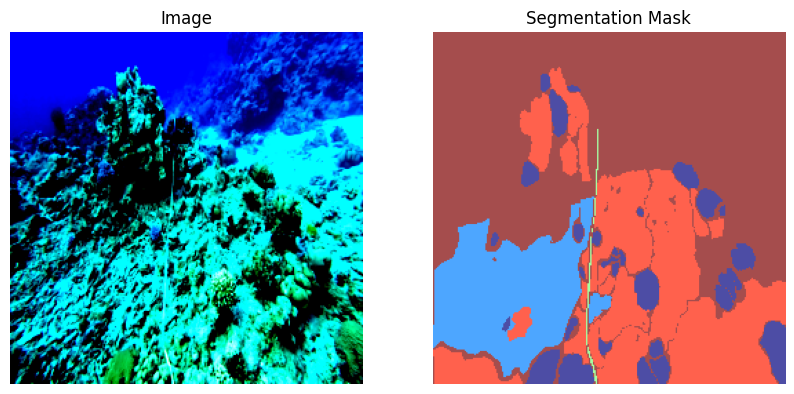

In [16]:
import matplotlib.pyplot as plt
import numpy as np

img, label = next(iter(data_loader))  # Get a batch

img_np = img[0].cpu().numpy()
label_np = label[0].cpu().numpy()

if img_np.shape[0] in [1, 3]:  # likely (C, H, W)
    img_np = np.transpose(img_np, (1, 2, 0))


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img_np.astype(np.float32))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmentation Mask')
plt.imshow(label_np, cmap='jet', alpha=0.7)  # Use alpha for overlay effect
plt.axis('off')

plt.show()


WandDB and Logging Setup

In [ ]:
import wandb
!wandb login
train_metrics = {

    'seg_loss' : [],
    'loss': [],
    'IOU' : []

}
eval_metrics = {
    'loss': [],
    'iou': [],
    'iou_class_mean': [],
    'iou_per_class_all': []
}
num_classes = 9
jaccard = JaccardIndex(task='multiclass', num_classes=num_classes, average=None)

def evaluate_metrics(pred,mask,num_classes):
    preds_net = torch.argmax(pred, dim=1) #[B, C, H, W]  →  [B, H, W]
    per_class_iou = jaccard(preds_net.detach().cpu(), mask.detach().cpu())  # [num_classes] return IOU per class
    mean_iou = per_class_iou.mean().item()

    return mean_iou, per_class_iou


wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

# **Define Model**

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=9
)
model.to(device)
summary(model, input_size=(1, 3, 256, 256))


# **Training Loop**

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Setup device and directories
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'Unet_withAug_300'
model_save_dir = './checkpoints'
log_file_path = './training_log_300.csv'
os.makedirs(model_save_dir, exist_ok=True)

# Hyperparameters and constants
num_classes = 9
epochs = 300
learning_rate = 1e-5

# Metric
jaccard = JaccardIndex(task='multiclass', num_classes=num_classes, average=None)

# Define your metric evaluation function
def evaluate_metrics(pred, mask, num_classes):
    preds_net = torch.argmax(pred, dim=1)  # [B, C, H, W] → [B, H, W]
    per_class_iou = jaccard(preds_net.detach().cpu(), mask.detach().cpu())  # [num_classes] IOU per class
    mean_iou = per_class_iou.mean().item()
    return mean_iou, per_class_iou

# Initialize model
torch.cuda.empty_cache()
# model = deeplabv3_resnet50(pretrained=True)
# model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=1.0e-3)
scheduler = OneCycleLR(optimizer,
                       max_lr=5.0e-4,
                       steps_per_epoch=len(data_loader),
                       epochs=epochs,
                       anneal_strategy='cos')

# DataLoaders (assumed defined)
# data_loader = ...
# val_data_loader = ...

best_iou = 0.0
log_data = []
wandb.init(
    project="CoralSegmentaton",
    name=model_name,
    config={
        "epochs": epochs,
        "learning_rate": learning_rate,
        "num_classes": num_classes,
        "model": "Unet-resnet50"
    }
)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    total_batches = len(data_loader)

    train_metrics = {'loss': [], 'iou': []}
    val_metrics = {'loss': [], 'iou': [], 'iou_class_mean': [], 'iou_per_class_all': []}

    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 30)

    progress_bar = tqdm(enumerate(data_loader), total=total_batches, leave=False)
    for batch_idx, (images, masks) in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # loss = criterion(outputs['out'], masks)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()

        batch_iou, per_class_iou = evaluate_metrics(outputs, masks, num_classes)
        # batch_iou, per_class_iou = evaluate_metrics(outputs['out'], masks, num_classes)
        running_iou += batch_iou

        train_metrics['loss'].append(loss.item())
        train_metrics['iou'].append(batch_iou)

        avg_loss = running_loss / (batch_idx + 1)
        avg_iou = running_iou / (batch_idx + 1)

        progress_bar.set_description(f"Batch {batch_idx+1}/{total_batches}")
        progress_bar.set_postfix(loss=f"{avg_loss:.4f}", iou=f"{avg_iou:.4f}")

    epoch_loss = running_loss / total_batches
    epoch_iou = running_iou / total_batches
    print(f"Epoch {epoch+1} finished. Average Loss: {epoch_loss:.4f}, Average IoU: {epoch_iou:.4f}")

    # Validation phase
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(val_data_loader, desc="validation"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # loss = criterion(outputs['out'], labels)
            loss = criterion(outputs, labels)
            val_metrics['loss'].append(loss.item())
            mean_iou, per_class_iou = evaluate_metrics(outputs, labels, num_classes)
            # mean_iou, per_class_iou = evaluate_metrics(outputs['out'], labels, num_classes)
            val_metrics['iou'].append(mean_iou)
            val_metrics['iou_class_mean'].append(mean_iou)
            val_metrics['iou_per_class_all'].append(per_class_iou.tolist())

    val_loss_avg = sum(val_metrics['loss']) / len(val_metrics['loss'])
    val_iou_avg = sum(val_metrics['iou']) / len(val_metrics['iou'])

    print(f"Validation Avg Loss: {val_loss_avg:.4f}, Avg IoU: {val_iou_avg:.4f}")

    # Log metrics
    log_data.append({
        'epoch': epoch + 1,
        'train_loss': epoch_loss,
        'train_iou': epoch_iou,
        'val_loss': val_loss_avg,
        'val_iou': val_iou_avg
    })
    wandb.log({
        "epoch": epoch + 1,
        "train/loss": epoch_loss,
        "train/iou": epoch_iou,
        "validate/loss": val_loss_avg,
        "validate/iou": val_iou_avg
})
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(model_save_dir, f"{model_name}_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'iou': epoch_iou,
            'best_iou': best_iou,
            'log_data': log_data,
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

    # Save best model with complete state
    if epoch_iou > best_iou:
        best_iou = epoch_iou
        best_model_path = os.path.join(model_save_dir, f"{model_name}_best_iou.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'iou': epoch_iou,
            'best_iou': best_iou,
            'log_data': log_data,
        }, best_model_path)
    print(f"New best model saved to {best_model_path} with IoU: {best_iou:.4f}")

    # Save training log
    pd.DataFrame(log_data).to_csv(log_file_path, index=False)
    print(f"Training log updated at {log_file_path}")

print("\nTraining complete!")


# **Load Models**

In [ ]:

def load_model_for_inference(checkpoint_path, num_classes=9, device='cuda'):
    """
    Load the trained model for inference

    Args:
        checkpoint_path: Path to the saved checkpoint (.pth file)
        num_classes: Number of classes (should match training)
        device: Device to load model on ('cuda' or 'cpu')

    Returns:
        model: Loaded model ready for inference
    """
    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=9
    )
    model.to(device)
    summary(model, input_size=(1, 3, 256, 256))


    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load the model state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()

    print(f"Model loaded successfully!")
    print(f"Best IoU from training: {checkpoint.get('best_iou', 'N/A'):.4f}")
    print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")

    return model

ckpt_path = "./checkpoints/Unet_withAug_300_best_iou.pth"
model = load_model_for_inference(ckpt_path)

# **Model Evaluation**

In [ ]:
model.to(device)
model.eval()
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

def compute_iou(pred, target, num_classes=9, ignore_index=255):
    """
    pred: (N, H, W) predicted labels
    target: (N, H, W) ground truth labels
    Returns: IoU for each class, ignoring ignore_index
    """
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # no ground truth for this class in batch
        else:
            ious.append(intersection / union)
    return ious

def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Denormalize image tensor for visualization
    """
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

def plot_predictions_with_gt(model, test_data_loader, device, num_samples=10, num_classes=9):
    """
    Plot original images with ground truth and predicted masks
    """
    # Use global colors array and create colormap
    # Add extra colors if needed
    global_colors = colors.copy()
    if len(global_colors) < num_classes:
        extra_colors = plt.cm.tab10(np.linspace(0, 1, num_classes - len(global_colors)))
        global_colors = np.vstack([global_colors, extra_colors])
    cmap = ListedColormap(global_colors[:num_classes])

    # Collect samples from multiple batches if needed
    all_images = []
    all_labels = []
    all_preds = []
    all_ious = []

    model.eval()
    samples_collected = 0

    with torch.no_grad():
        for images, labels in test_data_loader:
            if samples_collected >= num_samples:
                break

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Calculate IoU for each sample in the batch
            batch_size = images.shape[0]
            for i in range(batch_size):
                if samples_collected >= num_samples:
                    break

                # Get single sample
                single_pred = preds[i:i+1]
                single_label = labels[i:i+1]
                single_image = images[i:i+1]

                # Calculate IoU for this sample
                sample_ious = compute_iou(single_pred, single_label, num_classes)
                sample_miou = np.nanmean(sample_ious)

                # Store data
                all_images.append(single_image.cpu())
                all_labels.append(single_label.cpu())
                all_preds.append(single_pred.cpu())
                all_ious.append(sample_miou)

                samples_collected += 1

    # Create visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for idx in range(num_samples):
        # Get data for this sample
        img_tensor = all_images[idx][0]  # Remove batch dimension
        gt_mask = all_labels[idx][0].numpy()
        pred_mask = all_preds[idx][0].numpy()
        sample_iou = all_ious[idx]

        # Denormalize image for display
        img_display = denormalize_image(img_tensor).numpy().transpose(1, 2, 0)
        img_display = np.clip(img_display, 0, 1)

        # Plot original image
        axes[idx, 0].imshow(img_display)
        axes[idx, 0].set_title(f'Original Image {idx+1}')
        axes[idx, 0].axis('off')

        # Plot ground truth mask
        axes[idx, 1].imshow(gt_mask, cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[idx, 1].set_title(f'Ground Truth {idx+1}')
        axes[idx, 1].axis('off')

        # Plot predicted mask
        im = axes[idx, 2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[idx, 2].set_title(f'Prediction {idx+1}\nIoU: {sample_iou:.3f}')
        axes[idx, 2].axis('off')

    # Add colorbar
    cbar = plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, shrink=0.8)
    cbar.set_label('Class Labels')
    cbar.set_ticks(range(num_classes))
    cbar.set_ticklabels([f'Class {i}' for i in range(num_classes)])

    plt.tight_layout()
    plt.show()

# Define colors for visualization (moved outside function for reuse)
colors = [
    [114, 60, 61],     # coral      → **Dark Reddish Brown / Rosewood**
    [255, 255, 0],     # animal     → **Bright Yellow**
    [194, 178, 128],   # substrate  → **Tan / Khaki**
    [255, 0, 0],       # human      → **Bright Red**
    [8, 205, 12],      # object     → **Lime Green**
    [125, 222, 125],   # plant      → **Light Green / Pale Green**
    [255, 0, 134],     # trash      → **Hot Pink / Deep Pink**
    [125, 125, 125],   # unknown    → **Medium Gray**
    [255, 255, 255],   # void       → **White**
]


colors = np.array(colors) / 255.0  # Normalize to [0,1] range

# Evaluation loop with metrics collection
losses = []
miou_list = []
class_ious = {f'class_{i}': [] for i in range(9)}  # Assuming 9 classes

print("Starting evaluation...")
with torch.no_grad():
    for images, labels in tqdm(test_data_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # Calculate IoU
        preds = torch.argmax(outputs, dim=1)
        ious = compute_iou(preds, labels, num_classes=9)

        # Store per-class IoUs
        for i, iou in enumerate(ious):
            if not np.isnan(iou):
                class_ious[f'class_{i}'].append(iou)

        # Calculate mean IoU (ignoring NaNs)
        miou = np.nanmean(ious)
        if not np.isnan(miou):
            miou_list.append(miou)

# Print final metrics
mean_loss = np.mean(losses)
mean_miou = np.mean(miou_list) if miou_list else 0.0

print(f"\n=== EVALUATION RESULTS ===")
print(f"Final Mean Loss: {mean_loss:.4f}")
print(f"Final Mean IoU: {mean_miou:.4f}")

# Print per-class IoU
print(f"\n=== PER-CLASS IoU ===")
for i in range(9):
    class_iou_values = class_ious[f'class_{i}']
    if class_iou_values:
        class_mean_iou = np.mean(class_iou_values)
        class_std_iou = np.std(class_iou_values)
        print(f"Class {i}: {class_mean_iou:.4f} ± {class_std_iou:.4f} (n={len(class_iou_values)})")
    else:
        print(f"Class {i}: No valid samples")

# Plot metrics
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(losses, label='Loss', color='red', alpha=0.7)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss over Batches')
plt.legend()
plt.grid(True, alpha=0.3)

# mIoU plot
plt.subplot(1, 3, 2)
plt.plot(miou_list, label='mIoU', color='green', alpha=0.7)
plt.xlabel('Batch')
plt.ylabel('mIoU')
plt.title('Mean IoU over Batches')
plt.legend()
plt.grid(True, alpha=0.3)

# Per-class IoU bar plot
plt.subplot(1, 3, 3)
class_means = []
class_names = []
for i in range(9):
    if class_ious[f'class_{i}']:
        class_means.append(np.mean(class_ious[f'class_{i}']))
        class_names.append(f'C{i}')

if class_means:
    bars = plt.bar(class_names, class_means, alpha=0.7, color=colors[:len(class_means)])
    plt.xlabel('Class')
    plt.ylabel('Mean IoU')
    plt.title('Per-Class Mean IoU')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    # Add value labels on bars
    for bar, value in zip(bars, class_means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Plot sample predictions with ground truth
print("\nGenerating sample predictions visualization...")
plot_predictions_with_gt(model, test_data_loader, device, num_samples=10, num_classes=9)

print("\nEvaluation complete!")